In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

funciones utiles

In [2]:
def plot_volcans(dt='1750-01-01'):

    volcanes = {
    "Tambora\nVEI 7"     : {"fecha": "1812-01-01" , "ha": "center"},
    "Krakatau\nVEI 6"    : {"fecha": "1883-05-20" , "ha": "right"},
    "Santa\nMaría\nVEI 6" : {"fecha": "1902-10-24" , "ha": "center"},
    "Novarupta\nVEI 6"   : {"fecha": "1912-06-06" , "ha": "left"},
    "Pinatubo\nVEI 6"    : {"fecha": "1991-04-02" , "ha": "center"},
    }

    for nombre, data in volcanes.items():
        fecha_dt = pd.to_datetime(data['fecha'])
        if fecha_dt >= pd.to_datetime(dt):
            plt.axvline(
                fecha_dt,
                color="red",
                linestyle="--",
                alpha=0.4,
            )
            plt.text(
                fecha_dt,
                plt.ylim()[1],
                nombre,
                fontsize="smaller",
                color="red",
                ha=data["ha"],
                va="bottom",
            )


In [3]:
def detect_outliers_city(df_city):

    iso = IsolationForest(
        random_state=42,
        contamination='auto'
    )

    pred = iso.fit_predict(df_city)
    scores = iso.decision_function(df_city)

    df_city = df_city.copy()
    df_city['iso_label'] = pred
    df_city['iso_score'] = scores
    df_city['is_outlier'] = df_city['iso_label'] == -1

    return df_city

In [4]:
def coord_to_float(s: str) -> float:
    sign = -1 if s[-1] in ['S', 'W'] else 1
    return sign * float(s[:-1])

Carga y procesamiento rapido de datos

In [5]:
MajorCityCsv = './GlobalLandTemperaturesByMajorCity.csv'

In [10]:
MajorCityDf = pd.read_csv(
    MajorCityCsv,
    dtype_backend='pyarrow',
    engine='pyarrow'
)
MajorCityDf['year'] = MajorCityDf.dt.dt.year
MajorCityDf['month'] = MajorCityDf.dt.dt.month
MajorCityDf = MajorCityDf.sort_values('dt').reset_index().drop(['index'], axis=1)
MajorCityDf['Latitude'] = MajorCityDf['Latitude'].apply(coord_to_float)
MajorCityDf['Longitude'] = MajorCityDf['Longitude'].apply(coord_to_float)

MajorCityDf = MajorCityDf[MajorCityDf['year'] > 1800]

cols = ['AverageTemperature', 'AverageTemperatureUncertainty']
MajorCityDf[cols] = MajorCityDf[cols].interpolate(method='linear', limit_direction='forward')

In [ ]:
MajorCityDf["MA12"] = (
    MajorCityDf
    .groupby(["Country", "City"])["AverageTemperature"]
    .transform(lambda x: x.rolling(12, min_periods=1, center=True).mean())
)
MajorCityDf['dt'] = pd.to_datetime(MajorCityDf['dt'])
MajorCityDf.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,MA12
11754,1801-01-01,20.017,1.792,Ahmadabad,India,23.31,72.52,1801,1,19.328611
11755,1801-01-01,17.2535,1.9025,Aleppo,Syria,36.17,37.79,1801,1,18.906472
11756,1801-01-01,14.49,2.013,Alexandria,Egypt,31.35,30.16,1801,1,18.484333
11757,1801-01-01,-0.401,2.689,Ankara,Turkey,39.38,33.29,1801,1,8.398500
11758,1801-01-01,23.161,1.639,Bangalore,India,12.05,77.26,1801,1,21.196333


codificación de features

In [12]:
MajorCityDf['city_encoded'], _ = pd.factorize(MajorCityDf['City'])
MajorCityDf['country_encoded'], _ = pd.factorize(MajorCityDf['Country'])
MajorCityDf.head(2)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,MA12,city_encoded,country_encoded
11754,1801-01-01,20.017,1.792,Ahmadabad,India,23.31,72.52,1801,1,19.328611,0,0
11755,1801-01-01,17.2535,1.9025,Aleppo,Syria,36.17,37.79,1801,1,18.906472,1,1


Isolation Forest

In [13]:
feats = [
    'MA12', 
    'Latitude', 
    'Longitude', 
    'year', 
    'month'
]

In [14]:
MajorCityDf = MajorCityDf.combine_first(MajorCityDf.groupby('City', group_keys=False)[feats].apply(detect_outliers_city))

In [15]:
MajorCityDf.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,MA12,city_encoded,country_encoded,dt,is_outlier,iso_label,iso_score,month,year
11754,20.017,1.792,Ahmadabad,India,23.31,72.52,19.328611,0,0,1801-01-01,True,-1,-0.167865,1,1801
11755,17.2535,1.9025,Aleppo,Syria,36.17,37.79,18.906472,1,1,1801-01-01,True,-1,-0.125622,1,1801
11756,14.49,2.013,Alexandria,Egypt,31.35,30.16,18.484333,2,2,1801-01-01,True,-1,-0.196616,1,1801
11757,-0.401,2.689,Ankara,Turkey,39.38,33.29,8.398500,3,3,1801-01-01,True,-1,-0.182207,1,1801
11758,23.161,1.639,Bangalore,India,12.05,77.26,21.196333,4,0,1801-01-01,True,-1,-0.168535,1,1801


In [16]:
top_rare = MajorCityDf.sort_values('iso_score').head(50)
top_rare.head(2)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,MA12,city_encoded,country_encoded,dt,is_outlier,iso_label,iso_score,month,year
58451,7.373667,1.607,Luanda,Angola,-8.84,13.78,14.565056,95,45,1862-12-01,True,-1,-0.258777,12,1862
59639,7.319333,1.199,Luanda,Angola,-8.84,13.78,14.624250,95,45,1863-12-01,True,-1,-0.254681,12,1863


In [17]:
city_taget = 'Mashhad'

In [18]:
top_rare[top_rare['City'] == city_taget].sort_values('dt')

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,MA12,city_encoded,country_encoded,dt,is_outlier,iso_label,iso_score,month,year


<Axes: xlabel='dt', ylabel='MA12'>

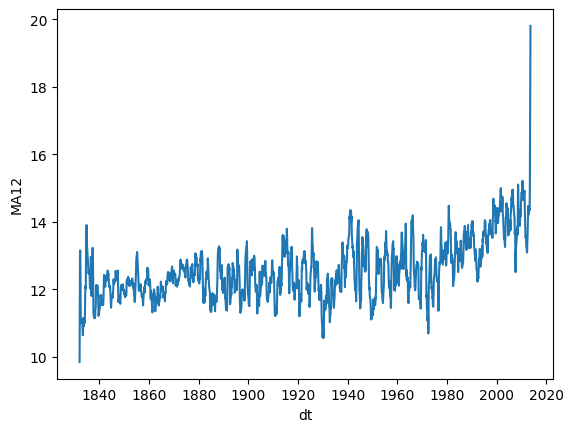

In [19]:
sn.lineplot(
    MajorCityDf[MajorCityDf['City'] == city_taget],
    x='dt',
    y='MA12'
)